<div id="container" style="position:relative;">
<div style="position:center; float:left"><h1>01 - CryptoPunk Price Prediction<br>Data Cleaning and Pre-Processing</h1></div>
<div style="position:relative; float:right"> 

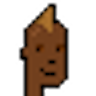
</div>

<hr> </hr>
Madelyn Goodman <br>
Brainstation Winter 2022 Capstone <br>
April 4, 2022
<hr>

# Introduction

Since the first NFT was created in 2014, the market has taken off to unprecedented heights. NFTs, or "Non-Fungible Tokens" are non-interchangeable units of data. Unlike a crypto currency like ether (ETH) where one ETH can be traded for another identical ETH, each NFT is distinct, kind of like a social security number. People can trade and exchange these unique hashes through smart contracts on the Ethereum blockchain. 
    
Woah, that was a lot of jargon... what is a blockchain? And what is Ethereum? 
    
A blockchain is essentially an immutable digital ledger that operates off of consensus. Meaning, at least 51% of all the servers maintaining this ledger have to agree that a transaction is valid. This results in a trustless system of exchange. Ethereum is a blockchain where transactions are executed using something called a smart contract. These are programs on the Ethereum blockchain that gets executed when a certain set of conditions are met, such as an exchange of ETH. NFTs use a specific kind of smart contract called an ERC-721 which are programmed to handle the transferability of these tokens and verify ownership. These contracts manage the exchange of ETH for the transfer of ownership of an NFT. 
    
What does this have to do with this Capstone project? As with any asset/investment, being able to predict or forecast the movement of price or value is what every smart investor hopes to do. 
    
CryptoPunks are an early NFT project that launched as free tokens in 2017 by <a href="https://www.larvalabs.com/cryptopunks">Larva Labs</a> that have since accumulated a trading volume of 1.7 billion dollars with the most valuable selling for 23.7 million dollars. In March 2022, Yuga Labs (creators of the Bored Ape NFTs) acquired management of the CryptoPunk collection. 

There are 5 different types of CryptoPunks, each with a unique set of characteristics contributing to varying levels of rarity of each punk. The unique sets of characteristics that contribute to value and the fixed number of NFTs in this project provide an excellent case study for movement of price of this digital asset. 
    
In addition to types and characteristics, the number of attributes each punk has, the value of ETH at the time of sale, who is buying and selling the punk, the number of days since the launch of the punks, average bids, and previous sale prices are all relevant and accessible features to use when building models to predict future sale prices. 

My primary source of data for this project was from a <a href="https://www.kaggle.com/datasets/tunguz/cryptopunks">Kaggle dataset</a> of data on Cryptopunk transactions from when the punks were first released in June 2017 until October 2021. I also got data on the daily closing price of Ethereum from <a href="https://www.tradingview.com/symbols/ETHUSD/">TradingView</a>. In this notebook I performed data cleaning as well as a significant amount of feature engineering on these two datasets. I generated several dataframes in the cleaning and engineering process that were all joined together at the end of the notebook.
<hr>

In [ ]:
#importing necessary packages
import numpy as np
import pandas as pd
import json

import os
import sqlite3

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.special import zeta

# Data Cleaning

In [ ]:
#Reading in data from JSON file
## REESTABLISH FILE PATH FOR SUBMISSION
with open('Data/txn_history-2021-10-07.jsonl') as f:  
    cp_txn_df = pd.read_json(f, lines = True)

In [ ]:
#Looking at the first 5 rows

print('The first 5 rows of Kaggle data:')
cp_txn_df.head()

The first 5 rows of Kaggle data:


,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


<hr>

**Initial thoughts on the data**

* `date` and `timestamp` appear to hold the same information
* `source` looks like it just has the one value all the way through - if not, should dummy it 
* `from_wallet_address` and `to_wallet_address` appear to be all none
* `type` and `accessories` are lists which will likely pose a challenge when vectorizing this data
* Want to know if `from` and `to` are both present for sales - if so, how to potentially use this data
<hr>

In [ ]:
#getting the shape of the data

print(f'The dataset has {cp_txn_df.shape[0]} rows and {cp_txn_df.shape[1]} columns')

The dataset has 167492 rows and 12 columns


In [ ]:
print('Number of CryptoPunks the dataset has data for:')
len(cp_txn_df['punk_id'].unique())

Number of CryptoPunks the dataset has data for:


10000

<hr>

The CryptoPunk NFT project released 10,000 punks. Transactions from all punks are included in this dataset. This number is fixed as this project only had one release. 
<hr>

In [ ]:
#looking at data types and amount of data per feature 

cp_txn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167492 entries, 0 to 167491
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   txn_type             167492 non-null  object        
 1   from                 167492 non-null  object        
 2   to                   167492 non-null  object        
 3   date                 167492 non-null  datetime64[ns]
 4   timestamp            167492 non-null  datetime64[ns]
 5   source               167492 non-null  object        
 6   eth                  127542 non-null  float64       
 7   punk_id              167492 non-null  int64         
 8   from_wallet_address  419 non-null     object        
 9   to_wallet_address    419 non-null     object        
 10  type                 167492 non-null  object        
 11  accessories          167492 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 15.3

<hr>

* only numeric variables right now are `eth` and `punk_id` - which is ordinal somewhat so that should be ok
* `from`, `to` should be dummied
* there is some feature engineering to make information about date/timing to be done to make it useful
<hr>

## Cleaning duplicates and missing data

### Missing data

In [ ]:
#Checking for missing values 

cp_txn_df.isna().sum()/cp_txn_df.shape[0]*100

txn_type                0.000000
from                    0.000000
to                      0.000000
date                    0.000000
timestamp               0.000000
source                  0.000000
eth                    23.851885
punk_id                 0.000000
from_wallet_address    99.749839
to_wallet_address      99.749839
type                    0.000000
accessories             0.000000
dtype: float64

<hr>

`from_wallet_address` and `to_wallet_address` are missing 99.7% of their data. This may be because this information is only for transfer transactions. An analysis was done to see if this information was also reflected in the `from` and `to` features. 

23% of `eth` is missing in this dataset - I checked if this was the case for transactions that are 'Sold' or 'Bids', or if this data was just missing for other transaction types such as transfers and claims. 
<hr>

In [ ]:
#values for txn_type

print('Transaction types:')
cp_txn_df['txn_type'].unique()

Transaction types:


array(['Bid Withdrawn', 'Bid', 'Sold', 'Offered', 'Transfer', 'Claimed',
       'Offer Withdrawn', '(Wrap)', '(Unwrap)'], dtype=object)

In [ ]:
#Looking at 'claimed' transations

print('Claimed transactions:')
cp_txn_df[cp_txn_df['txn_type'] == 'Claimed'].head()

Claimed transactions:


,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
40,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
103,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,1,None,None,[Male],"[Smile, Mohawk]"
133,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,2,None,None,[Female],[Wild Hair]
150,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,3,None,None,[Male],"[Wild Hair, Nerd Glasses, Pipe]"
162,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,4,None,None,[Male],"[Big Shades, Wild Hair, Earring, Goat]"


<hr>

All of the claimed transactions have NaN values for eth - this is because this transaction type represents when the punks were first released as free tokens.
<hr>

In [ ]:
#checking missing data on sale and bid transactions - what is going to be used in analysis

print('Missing data for Sale and Bid transactions: ')
cp_txn_df[(cp_txn_df['txn_type'] == 'Sold') | (cp_txn_df['txn_type'] == 'Bid')].isna().sum()/cp_txn_df.shape[0]*100

Missing data for Sale and Bid transactions: 


txn_type                0.000000
from                    0.000000
to                      0.000000
date                    0.000000
timestamp               0.000000
source                  0.000000
eth                     0.000000
punk_id                 0.000000
from_wallet_address    27.296826
to_wallet_address      27.296826
type                    0.000000
accessories             0.000000
dtype: float64

<hr>

Data is complete for the transaction types being used in this project except for `from_wallet_address` and `to_wallet_address` for 'Sold' and 'Bid' transactions - I was not worried about the missing data for the other transaction types, as these were to be dropped from the dataset since they weren't being used to build the model. 
<hr>

In [ ]:
#looking at observations where from_wallet_address was not missing

print('Observations not missing from_wallet_address: ')
cp_txn_df[cp_txn_df['from_wallet_address'].notna()]

Observations not missing from_wallet_address: 


,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
1180,Bid Withdrawn,0x89cbb1,,2021-10-07,2021-10-07 10:37:38,opensea,301.00,148,0x89cbb15c7ab08a39328b0e3ddf8cffa8d7c50899,,[Male],[Hoodie]
1181,Bid,0x89cbb1,,2021-10-07,2021-10-07 08:40:17,opensea,301.00,148,0x89cbb15c7ab08a39328b0e3ddf8cffa8d7c50899,,[Male],[Hoodie]
1540,Sold,0x904e43,0x3257d0,2021-10-05,2021-10-05 07:47:53,opensea,128.88,203,0x904e43d32b86475952ae8fb3c0c3bc09221e4987,0x3257d0a5e09bc140d255d062624f6fc573c2f839,[Male],"[Front Beard, Messy Hair, Regular Shades]"
1541,Bid Withdrawn,0x944f9f,,2021-10-05,2021-10-05 04:55:15,opensea,120.00,203,0x944f9f9b31f4de729b60e2c0b89de7cbdd5ac878,,[Male],"[Front Beard, Messy Hair, Regular Shades]"
1542,Bid,0x944f9f,,2021-10-05,2021-10-05 01:44:23,opensea,120.00,203,0x944f9f9b31f4de729b60e2c0b89de7cbdd5ac878,,[Male],"[Front Beard, Messy Hair, Regular Shades]"
...,...,...,...,...,...,...,...,...,...,...,...,...
164453,Bid,0x7ba652,,2021-10-05,2021-10-05 11:55:57,opensea,160.00,9849,0x7ba6527419152e17d78daccbb89a51ab71c8d200,,[Female],"[Red Mohawk, VR]"
164723,Transfer,0x0f6873,,2021-10-05,2021-10-05 12:44:16,opensea,NaN,9859,0x0f687377af469f882a526875de19b110c33c967a,,[Male],"[Silver Chain, Regular Shades, Mohawk Dark]"
165031,Offer Withdrawn,disco.eth,,2021-10-03,2021-10-03 19:32:37,opensea,NaN,9868,0xf36972bbff0bb63dbc8f2c8a93625647b32e024b,,[Female],"[Hot Lipstick, Earring, Mohawk Dark]"
167251,Offered,0x023ef7,,2021-10-05,2021-10-05 16:44:02,opensea,175.00,9982,0x023ef73d4c6de80dd3e52b8aae579b8f0e5cbeb4,,[Female],"[Stringy Hair, VR, Earring]"


In [ ]:
#looking at observations where to_wallet_address was not missing

print('Observations not missing to_wallet_address: ')
cp_txn_df[cp_txn_df['to_wallet_address'].notna()]

Observations not missing to_wallet_address: 


,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
1180,Bid Withdrawn,0x89cbb1,,2021-10-07,2021-10-07 10:37:38,opensea,301.00,148,0x89cbb15c7ab08a39328b0e3ddf8cffa8d7c50899,,[Male],[Hoodie]
1181,Bid,0x89cbb1,,2021-10-07,2021-10-07 08:40:17,opensea,301.00,148,0x89cbb15c7ab08a39328b0e3ddf8cffa8d7c50899,,[Male],[Hoodie]
1540,Sold,0x904e43,0x3257d0,2021-10-05,2021-10-05 07:47:53,opensea,128.88,203,0x904e43d32b86475952ae8fb3c0c3bc09221e4987,0x3257d0a5e09bc140d255d062624f6fc573c2f839,[Male],"[Front Beard, Messy Hair, Regular Shades]"
1541,Bid Withdrawn,0x944f9f,,2021-10-05,2021-10-05 04:55:15,opensea,120.00,203,0x944f9f9b31f4de729b60e2c0b89de7cbdd5ac878,,[Male],"[Front Beard, Messy Hair, Regular Shades]"
1542,Bid,0x944f9f,,2021-10-05,2021-10-05 01:44:23,opensea,120.00,203,0x944f9f9b31f4de729b60e2c0b89de7cbdd5ac878,,[Male],"[Front Beard, Messy Hair, Regular Shades]"
...,...,...,...,...,...,...,...,...,...,...,...,...
164453,Bid,0x7ba652,,2021-10-05,2021-10-05 11:55:57,opensea,160.00,9849,0x7ba6527419152e17d78daccbb89a51ab71c8d200,,[Female],"[Red Mohawk, VR]"
164723,Transfer,0x0f6873,,2021-10-05,2021-10-05 12:44:16,opensea,NaN,9859,0x0f687377af469f882a526875de19b110c33c967a,,[Male],"[Silver Chain, Regular Shades, Mohawk Dark]"
165031,Offer Withdrawn,disco.eth,,2021-10-03,2021-10-03 19:32:37,opensea,NaN,9868,0xf36972bbff0bb63dbc8f2c8a93625647b32e024b,,[Female],"[Hot Lipstick, Earring, Mohawk Dark]"
167251,Offered,0x023ef7,,2021-10-05,2021-10-05 16:44:02,opensea,175.00,9982,0x023ef73d4c6de80dd3e52b8aae579b8f0e5cbeb4,,[Female],"[Stringy Hair, VR, Earring]"


<hr>

It appears that `from` and `to` are simply appreviations of `from_wallet_address` and `to_wallet_address`. I decided to drop `from_wallet_address` and `to_wallet_address` as I was confident that this information was captured in the alternate columns.
<hr>

In [ ]:
#dropping from_wallet_address and to_wallet_address

cp_txn_df.drop(['from_wallet_address', 'to_wallet_address'], axis=1, inplace=True)

In [ ]:
#checking if the columns were actually dropped 

cp_txn_df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


<hr>

I next wanted to create a dataframe of just Sales and Bids to continue cleaning from there. Since I was building a model to predict sale price, I wasn't concerned with the amounts offered or the events of the offers and bids being withdrawn. I went into the model building process under the hypothesis that I could predict sale prices based on previous sale prices and average bids. This hypothesis was informed by a <a href="https://www.nature.com/articles/s41598-021-00053-8">paper by Matthieu Nadini</a> who used machine learning techniques to map trends in NFT trading. 

As I didn't want to concerne myself with missing or duplicate data having to do with observations I wasn't going to be using, I created a dataframe to use going forward of just Sale and Bid data. 
<hr>

In [ ]:
#Seeing how many transactions there were by transaction type

print('Number of observations by transaction type: ')
cp_txn_df['txn_type'].value_counts()

Number of observations by transaction type: 


Offered            65467
Bid                26808
Sold               18979
Bid Withdrawn      16342
Transfer           14225
Offer Withdrawn    10372
Claimed            10000
(Wrap)              2773
(Unwrap)            2526
Name: txn_type, dtype: int64

<hr>

There was a significant enough number of observations of Sold and Bid transactions to build my model from, so I went forward with this strategy.
<hr>

In [ ]:
#creating a data frame with just bids/sales data 

cp_txn_df2 = cp_txn_df[
    (cp_txn_df['txn_type']=='Bid') | 
    (cp_txn_df['txn_type']=='Sold')
    ]
cp_txn_df2.reset_index(inplace=True, drop=True)

In [ ]:
cp_txn_df2.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,type,accessories
0,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid,0x2e5e22,,2021-08-29,2021-08-29,larvalabs,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x983ace,,2021-04-11,2021-04-11,larvalabs,250.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid,0xd7510a,,2021-02-20,2021-02-20,larvalabs,100.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [ ]:
#checking that everything went through

cp_txn_df2['txn_type'].value_counts()

Bid     26808
Sold    18979
Name: txn_type, dtype: int64

<hr>

Only the sale and bid transaction were in my new dataframe. I went forwrad evaluating for missing data and duplicate data using this set. 
<hr>

In [ ]:
#checking missing data in this dataframe 

cp_txn_df2.isna().sum()/cp_txn_df2.shape[0]*100

txn_type       0.0
from           0.0
to             0.0
date           0.0
timestamp      0.0
source         0.0
eth            0.0
punk_id        0.0
type           0.0
accessories    0.0
dtype: float64

<hr>

There were no missing values in the sale and bid dataset.
<hr>

### Duplicate data

In [ ]:
#checking on data types again 
cp_txn_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45787 entries, 0 to 45786
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   txn_type     45787 non-null  object        
 1   from         45787 non-null  object        
 2   to           45787 non-null  object        
 3   date         45787 non-null  datetime64[ns]
 4   timestamp    45787 non-null  datetime64[ns]
 5   source       45787 non-null  object        
 6   eth          45787 non-null  float64       
 7   punk_id      45787 non-null  int64         
 8   type         45787 non-null  object        
 9   accessories  45787 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 3.5+ MB


<hr>

Seemed that `date` and `timestamp` hold the same information... checked if these were in fact duplicate columns.
<hr>

In [ ]:
#checking if the date and timestamp columns hold the same data

print('The number of fields that differed between the date and timestamp columns: ')
cp_txn_df2.shape[0] - cp_txn_df2['date'].isin(cp_txn_df2['timestamp']).sum()

The number of fields that differed between the date and timestamp columns: 


383

In [ ]:
#looking at the rows that differed 

print('The following are the rows that had different information in the date and timestamp columns: ')
cp_txn_df2[~cp_txn_df2['date'].isin(cp_txn_df2['timestamp'])]

The following are the rows that had different information in the date and timestamp columns: 


,txn_type,from,to,date,timestamp,source,eth,punk_id,type,accessories
165,Bid,0x65b1b9,,2021-10-04,2021-10-04 02:22:15,opensea,135.00,15,[Male],"[Luxurious Beard, Wild Hair, Regular Shades]"
482,Bid,0x89cbb1,,2021-10-07,2021-10-07 08:40:17,opensea,301.00,148,[Male],[Hoodie]
493,Sold,0x1919db,0x53fc45,2021-10-02,2021-10-02 00:06:50,opensea,138.99,150,[Female],"[Purple Lipstick, Earring]"
494,Sold,0xfeeb2d,0x1919db,2021-10-01,2021-10-01 00:57:43,opensea,128.00,150,[Female],"[Purple Lipstick, Earring]"
585,Sold,0x904e43,0x3257d0,2021-10-05,2021-10-05 07:47:53,opensea,128.88,203,[Male],"[Front Beard, Messy Hair, Regular Shades]"
...,...,...,...,...,...,...,...,...,...,...
44959,Bid,0x7ba652,,2021-10-05,2021-10-05 11:55:57,opensea,160.00,9849,[Female],"[Red Mohawk, VR]"
45096,Sold,0x944f9f,0x6f6ab4,2021-10-04,2021-10-04 10:32:20,opensea,116.00,9868,[Female],"[Hot Lipstick, Earring, Mohawk Dark]"
45097,Sold,disco.eth,NullAddress,2021-10-04,2021-10-04 10:20:33,opensea,110.00,9868,[Female],"[Hot Lipstick, Earring, Mohawk Dark]"
45098,Bid,0x944f9f,,2021-10-04,2021-10-04 08:14:01,opensea,110.00,9868,[Female],"[Hot Lipstick, Earring, Mohawk Dark]"


<hr>

Looking at the data that had different information in the `date` and `timestamp` columns, it appears that this data was all from Opensea, therfore, I investigated this further.
<hr>

In [ ]:
#finding the source of the rows with differing information
print('Source of data with differing date and timestamp columns: ')
cp_txn_df2[~cp_txn_df2['date'].isin(cp_txn_df2['timestamp'])]['source'].unique()

Source of data with differing date and timestamp columns: 


array(['opensea'], dtype=object)

<hr>

It appeared that only Opensea had actual timestamps for their sales as opposed to the data from Larva Labs. Since timestamps could not be generated retrospectively, I decided to drop the `timestamp` column, as this information for the observations from Opensea was still reflected in the `date` column.
<hr>

In [ ]:
#dropping timestamp column
cp_txn_df2.drop('timestamp', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
cp_txn_df2.head()

,txn_type,from,to,date,source,eth,punk_id,type,accessories
0,Bid,0xe73a1d,,2021-09-01,larvalabs,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0x2e5e22,,2021-09-01,larvalabs,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid,0x2e5e22,,2021-08-29,larvalabs,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x983ace,,2021-04-11,larvalabs,250.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid,0xd7510a,,2021-02-20,larvalabs,100.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


### Preprocessing `type` and `accessories` columns

<hr>

`type` and `accessories` had their data stored in lists within the dataframe. I planned on vectorizing these columns, therefore, I had to pull these data out of the list format.

I had to deal with this before looking further into duplicate information, as pandas does not respond well to lists stored in series. 
<hr>

In [ ]:
#creating a function to pull accessories and types out of lists
def list_to_string(trait):

  '''
  Takes the column with data stored in a list and converts it to strings

  parameters
  ------------------------------
  trait = the column with information trapped in lists

  returns
  ------------------------------
  This function returns the values in the list as strings within each series element

  '''
        
  start = trait
  string= ', '.join([str(item) for item in start])
        
  return string

In [ ]:
#applying the function to the accessories column
cp_txn_df2['cp_traits'] = cp_txn_df2['accessories'].apply(list_to_string)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
cp_txn_df2.head()

,txn_type,from,to,date,source,eth,punk_id,type,accessories,cp_traits
0,Bid,0xe73a1d,,2021-09-01,larvalabs,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]","Green Eye Shadow, Earring, Blonde Bob"
1,Bid,0x2e5e22,,2021-09-01,larvalabs,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]","Green Eye Shadow, Earring, Blonde Bob"
2,Bid,0x2e5e22,,2021-08-29,larvalabs,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]","Green Eye Shadow, Earring, Blonde Bob"
3,Bid,0x983ace,,2021-04-11,larvalabs,250.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]","Green Eye Shadow, Earring, Blonde Bob"
4,Bid,0xd7510a,,2021-02-20,larvalabs,100.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]","Green Eye Shadow, Earring, Blonde Bob"


<hr>

The function I defined worked to pull the accessories out of lists into a new column of just strings. I dropped the old column and applied the function to the `type` column to fix that as well. 
<hr>

In [ ]:
#dropping accessories column
cp_txn_df2.drop('accessories', axis=1, inplace=True)
cp_txn_df2.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,txn_type,from,to,date,source,eth,punk_id,type,cp_traits
0,Bid,0xe73a1d,,2021-09-01,larvalabs,321.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob"
1,Bid,0x2e5e22,,2021-09-01,larvalabs,320.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob"
2,Bid,0x2e5e22,,2021-08-29,larvalabs,263.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob"
3,Bid,0x983ace,,2021-04-11,larvalabs,250.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob"
4,Bid,0xd7510a,,2021-02-20,larvalabs,100.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob"


In [ ]:
#pulling type out of list format 
cp_txn_df2['cp_type'] = cp_txn_df2['type'].apply(list_to_string)
cp_txn_df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,txn_type,from,to,date,source,eth,punk_id,type,cp_traits,cp_type
0,Bid,0xe73a1d,,2021-09-01,larvalabs,321.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob",Female
1,Bid,0x2e5e22,,2021-09-01,larvalabs,320.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob",Female
2,Bid,0x2e5e22,,2021-08-29,larvalabs,263.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob",Female
3,Bid,0x983ace,,2021-04-11,larvalabs,250.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob",Female
4,Bid,0xd7510a,,2021-02-20,larvalabs,100.0,0,[Female],"Green Eye Shadow, Earring, Blonde Bob",Female


In [ ]:
#dropping type column
cp_txn_df2.drop('type', axis=1, inplace=True)
cp_txn_df2.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
0,Bid,0xe73a1d,,2021-09-01,larvalabs,321.0,0,"Green Eye Shadow, Earring, Blonde Bob",Female
1,Bid,0x2e5e22,,2021-09-01,larvalabs,320.0,0,"Green Eye Shadow, Earring, Blonde Bob",Female
2,Bid,0x2e5e22,,2021-08-29,larvalabs,263.0,0,"Green Eye Shadow, Earring, Blonde Bob",Female
3,Bid,0x983ace,,2021-04-11,larvalabs,250.0,0,"Green Eye Shadow, Earring, Blonde Bob",Female
4,Bid,0xd7510a,,2021-02-20,larvalabs,100.0,0,"Green Eye Shadow, Earring, Blonde Bob",Female


### Duplicate data continued

In [ ]:
#checking on rows that are duplicated

print('The % of rows that are duplicates: ')
cp_txn_df2.duplicated().sum()/cp_txn_df2.shape[0]*100

The % of rows that are duplicates: 


0.49358988359141237

In [ ]:
#looking at rows that are duplicated

print('Duplicated rows: ')
cp_txn_df2[cp_txn_df2.duplicated()]

Duplicated rows: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
123,Bid,jmg,,2019-03-29,larvalabs,1.50,9,"Clown Nose, Police Cap, Big Beard",Male
890,Bid,0x011e44,,2018-01-23,larvalabs,0.01,323,Mohawk Dark,Male
891,Bid,0x011e44,,2018-01-23,larvalabs,0.01,323,Mohawk Dark,Male
923,Bid,0xc21c1d,,2021-06-26,larvalabs,0.07,334,"Wild Hair, Big Beard",Male
947,Bid,cryptopu…,,2021-04-17,larvalabs,70.00,339,"Mole, Cap, Big Shades, Black Lipstick, Earring",Female
...,...,...,...,...,...,...,...,...,...
45115,Sold,0x4d26d1,NullAddress,2021-09-20,opensea,104.50,9873,"Handlebars, Wild Hair",Male
45116,Bid,0x1919db,,2021-09-20,opensea,104.50,9873,"Handlebars, Wild Hair",Male
45117,Bid,0x1262d7,,2021-09-20,opensea,104.50,9873,"Handlebars, Wild Hair",Male
45120,Bid,0x1262d7,,2021-09-19,opensea,106.00,9873,"Handlebars, Wild Hair",Male


In [ ]:
#looking only at duplicated sale data

dup_txn = cp_txn_df2[cp_txn_df2.duplicated()]

print('Duplicated sale data: ')
dup_txn[dup_txn['txn_type'] == 'Sold']

Duplicated sale data: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
1723,Sold,0xd97a2f,0xa3280e,2021-09-23,opensea,220.00,610,"Cap Forward, Big Shades, Earring",Male
3826,Sold,rawthko.eth,0x6d6a44,2021-09-21,opensea,100.00,1267,"Purple Eye Shadow, Crazy Hair",Female
5500,Sold,0x752f4a,0x46ea9e,2021-09-22,opensea,115.00,1693,"Clown Eyes Green, Crazy Hair",Female
8065,Sold,0xf4ea62,0xe545c0,2021-09-22,opensea,101.00,2280,"Messy Hair, Goat",Male
9337,Sold,0x97db27,0xd9c980,2021-09-23,opensea,109.99,2524,"Stringy Hair, Eye Mask, Earring",Male
10725,Sold,fi5hy.eth,0x038f72,2021-09-21,opensea,110.00,2825,"Bandana, Handlebars, Small Shades",Male
12207,Sold,0xa27697,thecitadel.eth,2021-09-23,opensea,115.00,3097,"Police Cap, Earring, Normal Beard",Male
13297,Sold,0x7af332,joe9109.eth,2021-09-24,opensea,113.80,3311,"Tassle Hat, Spots, Purple Lipstick, Earring",Female
13570,Sold,0x504879,0x38d0db,2021-09-22,opensea,104.69,3356,"Knitted Cap, Regular Shades",Female
16394,Sold,gaus,parttty6,2020-10-08,larvalabs,0.00,3880,"Handlebars, Do-rag, Mole",Male


In [ ]:
#Looking at punk 610 to see the duplicated data

print('Data for punk 610 to observe the duplicates: ')
cp_txn_df2[cp_txn_df2['punk_id']==610]

Data for punk 610 to observe the duplicates: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
1722,Sold,0xd97a2f,0xa3280e,2021-09-23,opensea,220.00,610,"Cap Forward, Big Shades, Earring",Male
1723,Sold,0xd97a2f,0xa3280e,2021-09-23,opensea,220.00,610,"Cap Forward, Big Shades, Earring",Male
1724,Sold,0x142ae8,0xd97a2f,2021-07-04,larvalabs,28.88,610,"Cap Forward, Big Shades, Earring",Male
1725,Bid,0x07cc65,,2021-05-07,larvalabs,15.00,610,"Cap Forward, Big Shades, Earring",Male
1726,Sold,0x13816f,jester88…,2021-02-15,larvalabs,10.50,610,"Cap Forward, Big Shades, Earring",Male
1727,Sold,0x3ba9cd,0x13816f,2020-09-30,larvalabs,5.75,610,"Cap Forward, Big Shades, Earring",Male
1728,Sold,Carlini8,0x3ba9cd,2020-09-25,larvalabs,4.00,610,"Cap Forward, Big Shades, Earring",Male
1729,Sold,0xc352b5,Carlini8,2020-01-01,larvalabs,2.00,610,"Cap Forward, Big Shades, Earring",Male
1730,Bid,Carlini8,,2020-01-01,larvalabs,2.00,610,"Cap Forward, Big Shades, Earring",Male


In [ ]:
#looking at duplicated bids

print('Duplicated bid data: ')
dup_txn[dup_txn['txn_type'] == 'Bid']

Duplicated bid data: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
123,Bid,jmg,,2019-03-29,larvalabs,1.50,9,"Clown Nose, Police Cap, Big Beard",Male
890,Bid,0x011e44,,2018-01-23,larvalabs,0.01,323,Mohawk Dark,Male
891,Bid,0x011e44,,2018-01-23,larvalabs,0.01,323,Mohawk Dark,Male
923,Bid,0xc21c1d,,2021-06-26,larvalabs,0.07,334,"Wild Hair, Big Beard",Male
947,Bid,cryptopu…,,2021-04-17,larvalabs,70.00,339,"Mole, Cap, Big Shades, Black Lipstick, Earring",Female
...,...,...,...,...,...,...,...,...,...
44964,Bid,0xf4d89c,,2021-08-14,larvalabs,70.00,9849,"Red Mohawk, VR",Female
45116,Bid,0x1919db,,2021-09-20,opensea,104.50,9873,"Handlebars, Wild Hair",Male
45117,Bid,0x1262d7,,2021-09-20,opensea,104.50,9873,"Handlebars, Wild Hair",Male
45120,Bid,0x1262d7,,2021-09-19,opensea,106.00,9873,"Handlebars, Wild Hair",Male


In [ ]:
#looking at punk 9 transactions to observe the duplicates

print('Data for punk 610 to observe the duplicates: ')
cp_txn_df2[cp_txn_df2['punk_id']==9]

Data for punk 610 to observe the duplicates: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
113,Bid,jmg,,2020-10-13,larvalabs,36.00,9,"Clown Nose, Police Cap, Big Beard",Male
114,Bid,jmg,,2020-09-28,larvalabs,27.50,9,"Clown Nose, Police Cap, Big Beard",Male
115,Bid,jmg,,2020-09-26,larvalabs,25.00,9,"Clown Nose, Police Cap, Big Beard",Male
116,Bid,jmg,,2020-09-20,larvalabs,20.00,9,"Clown Nose, Police Cap, Big Beard",Male
117,Bid,Alex3422,,2020-06-01,larvalabs,6.00,9,"Clown Nose, Police Cap, Big Beard",Male
118,Bid,Pranksy,,2020-05-20,larvalabs,4.00,9,"Clown Nose, Police Cap, Big Beard",Male
119,Bid,jmg,,2020-01-20,larvalabs,5.00,9,"Clown Nose, Police Cap, Big Beard",Male
120,Bid,jmg,,2019-08-26,larvalabs,2.00,9,"Clown Nose, Police Cap, Big Beard",Male
121,Bid,0xa1179f,,2019-04-17,larvalabs,1.80,9,"Clown Nose, Police Cap, Big Beard",Male
122,Bid,jmg,,2019-03-29,larvalabs,1.50,9,"Clown Nose, Police Cap, Big Beard",Male


In [ ]:
dup_txn.shape

(226, 9)

<hr>

It seemed like there might have been an error compiling the information that resulted in these duplicates. Logically it doesn't make sense for there to be a sale of the same price from and to the same people to happen on the same day as well as a bid back-to-back. Without being able to consult with those managing the data sources to confirm what lead to these duplicate values, since only 0.5% of the dataset was duplicated, I decided to drop these values. 
<hr>

In [ ]:
#dropping duplicates
cp_txn_df2.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
#checking if any duplicates remained

print('Number of duplicates remaining: ')
cp_txn_df2.duplicated().sum()

Number of duplicates remaining: 


0

In [ ]:
cp_txn_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45561 entries, 0 to 45786
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   txn_type   45561 non-null  object        
 1   from       45561 non-null  object        
 2   to         45561 non-null  object        
 3   date       45561 non-null  datetime64[ns]
 4   source     45561 non-null  object        
 5   eth        45561 non-null  float64       
 6   punk_id    45561 non-null  int64         
 7   cp_traits  45561 non-null  object        
 8   cp_type    45561 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 3.5+ MB


<hr>

The data now seemed free of NaNs and duplicates. I then sorted the data by `punk_id` and `date` then moved on to compiling and cleaning data on ETH closing prices. 
<hr>

In [ ]:
#sorting the data on punk_id and date
cp_txn_df2.sort_values(['punk_id', 'date'], ascending=(True, True), inplace=True, ignore_index=True)
cp_txn_df2.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female
1,Bid,0x00d7c9,,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female
2,Bid,0x948a10,,2017-06-23,larvalabs,0.67,0,"Green Eye Shadow, Earring, Blonde Bob",Female
3,Bid,0x717403,,2017-06-25,larvalabs,0.05,0,"Green Eye Shadow, Earring, Blonde Bob",Female
4,Bid,0x7760e0,,2017-07-02,larvalabs,1.30,0,"Green Eye Shadow, Earring, Blonde Bob",Female


In [ ]:
#ensuring that the bottom of the dataframe was also sorted
cp_txn_df2.tail()

,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type
45556,Bid,0x9243b1,,2021-03-16,larvalabs,0.10,9999,"Mohawk, Nerd Glasses",Female
45557,Bid,0xaa6099,,2021-04-20,larvalabs,17.50,9999,"Mohawk, Nerd Glasses",Female
45558,Bid,cadboros…,,2021-04-27,larvalabs,0.10,9999,"Mohawk, Nerd Glasses",Female
45559,Bid,0x20ed17,,2021-05-12,larvalabs,0.22,9999,"Mohawk, Nerd Glasses",Female
45560,Bid,0xded84b,,2021-08-01,larvalabs,10.00,9999,"Mohawk, Nerd Glasses",Female


## Cleaning Tradingview ETHXUSD data

In [ ]:
#reading in data on daily closing price of eth

eth_usd_df = pd.read_csv('Data/COINBASE_ETHUSD_1D.csv')

In [ ]:
#looking at the first few rows of ETH data

eth_usd_df.head()

,time,open,high,low,close,Volume,Volume MA,Conversion Line,Base Line,Lagging Span,...,Plot.16,Plot.17,MA.1,Range High Percentile,Range High Percentile.1,Williams Vix Fix,Upper Band,Vix,Plot.18,RSI
0,2016-05-22T20:00:00-04:00,13.91,13.91,13.61,13.61,1.0,NaN,NaN,NaN,13.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-05-23T20:00:00-04:00,13.68,13.74,12.00,12.77,2754.0,NaN,NaN,NaN,13.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-05-24T20:00:00-04:00,13.00,13.18,11.93,12.61,9696.0,NaN,NaN,NaN,13.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-05-25T20:00:00-04:00,12.61,12.95,12.15,12.47,2993.0,NaN,NaN,NaN,14.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-05-26T20:00:00-04:00,12.47,12.47,10.25,10.98,19329.0,NaN,NaN,NaN,14.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#looking at the shape of the data

print(f'There are {eth_usd_df.shape[0]} rows and {eth_usd_df.shape[1]} columns in the ETHXUSD dataset')

There are 2108 rows and 52 columns in the ETHXUSD dataset


<hr>

I was only interested in getting the closing price of ETH per day from this dataset. I therefore got rid of all the columns other than `close` and `time`. 
<hr>

In [ ]:
#getting a dataframe with only date and close
eth_usd_df2 = eth_usd_df[['time', 'close']]
eth_usd_df2.head()

,time,close
0,2016-05-22T20:00:00-04:00,13.61
1,2016-05-23T20:00:00-04:00,12.77
2,2016-05-24T20:00:00-04:00,12.61
3,2016-05-25T20:00:00-04:00,12.47
4,2016-05-26T20:00:00-04:00,10.98


In [ ]:
#checking datatypes

eth_usd_df2.dtypes

time      object
close    float64
dtype: object

<hr>

`time` needed to be converted to a datetime format and shed the timestamp, as I had decided to only keep the `date` column without a timestamp in the punk transaction dataframe. 
<hr>

In [ ]:
#checking for missing values 

print('Missing values per columns: ')
eth_usd_df2.isna().sum()

Missing values per columns: 


time     0
close    0
dtype: int64

In [ ]:
#checking for duplicates

print('Number of duplicate rows: ')
eth_usd_df2.duplicated().sum()

Number of duplicate rows: 


0

<hr>

There was no missing data or duplicate rows in this data.
<hr>

In [ ]:
#Looking at the spread of the data on ETH close

eth_usd_df2.describe()

,close
count,2108.000000
mean,771.850685
std,1126.623225
min,6.750000
25%,141.682500
50%,261.585000
75%,696.837500
max,4811.900000


In [ ]:
#converting time to a datetime format

eth_usd_df2['time'] = pd.to_datetime(eth_usd_df2['time'], utc=True)
eth_usd_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2108 entries, 0 to 2107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   time    2108 non-null   datetime64[ns, UTC]
 1   close   2108 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 33.1 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#removing timestamp from time column to compare with transaction dataframe

eth_usd_df2['time'] = eth_usd_df2['time'].dt.date

#converting the column back to datetime format 

eth_usd_df2['time'] = pd.to_datetime(eth_usd_df2['time'])

display(eth_usd_df2.head())
print(eth_usd_df2.info())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,time,close
0,2016-05-23,13.61
1,2016-05-24,12.77
2,2016-05-25,12.61
3,2016-05-26,12.47
4,2016-05-27,10.98


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2108 entries, 0 to 2107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    2108 non-null   datetime64[ns]
 1   close   2108 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.1 KB
None


In [ ]:
#renaming the date column from 'time' to 'date'

eth_usd_df2.rename(columns={'time':'date'}, inplace=True)
eth_usd_df2.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,close
0,2016-05-23,13.61
1,2016-05-24,12.77
2,2016-05-25,12.61
3,2016-05-26,12.47
4,2016-05-27,10.98


<hr>

The `time` column was now in the datetime format without the timestamp and named the same as the associated column in the punk transaction dataframe. The data on daily closings was now ready to be merged with the punk transaction data using the date as the key between the two.
<hr>

In [ ]:
#merging eth price with cryptopunk transaction data on date

cp_txn_df2 = pd.merge(cp_txn_df2, eth_usd_df2, how='left', left_on=['date'], right_on=['date'])
cp_txn_df2.head()

,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99
1,Bid,0x00d7c9,,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99
2,Bid,0x948a10,,2017-06-23,larvalabs,0.67,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99
3,Bid,0x717403,,2017-06-25,larvalabs,0.05,0,"Green Eye Shadow, Earring, Blonde Bob",Female,278.49
4,Bid,0x7760e0,,2017-07-02,larvalabs,1.30,0,"Green Eye Shadow, Earring, Blonde Bob",Female,285.00


# Feature engineering 

<hr>

The dataset did not include all the features I wanted to look at that I hypothesized would be related to sale price. Luckily, there was enough related data for me to engineer these features:

* `whale_buy`
* `whale_sell`
* `bid_count`
* `mean_bid`
* `num_prev_sales`
* `prev_price`
* `days_since_claim`
* `punk_rarity`
* Traits vectors 
* Types vectors 
* Source


Explanations of these features are included in the data dictionary. 
<hr>

## `whale_buy`

In [ ]:
cp_txn_df2.dtypes

txn_type             object
from                 object
to                   object
date         datetime64[ns]
source               object
eth                 float64
punk_id               int64
cp_traits            object
cp_type              object
close               float64
dtype: object

<hr>

Since the data on buyers and sellers were objects, I wanted to put them in a format that a model could interpret and that would possibly be informative on price. There are certain addresses that come up more than others when it comes to buying and selling, so I thought a good way to solve this problem would be to encode the frequent buys and frquent sellers as dummy variables. These variables were called `whale_buy` and `whale_sell` as the term "whale" is typically used for someone who holds a lot of an asset. 
<hr>

In [ ]:
#making df of counts of buys per buyer
to_df = pd.DataFrame(cp_txn_df2['to'].value_counts())
to_df = to_df[1:]
to_df.head()

,to
Pranksy,542
0x269616,227
0x1919db,173
GoWest23,162
Carlini8,156


<hr>

I used an arbitrary cut off of 100 to denote those who were "whales" or not. 
<hr>

In [ ]:
#making new column to denote big buyers
to_df['whale_buy'] = np.where(to_df['to'] >= 100, 1, 0)
to_df.drop('to', axis=1, inplace=True)
to_df.head()

,whale_buy
Pranksy,1
0x269616,1
0x1919db,1
GoWest23,1
Carlini8,1


In [ ]:
#looking at the end of the dataframe

to_df.tail()

,whale_buy
0xde7c26,0
0x83e799,0
0x4db323,0
0xc991fd,0
0xfad116,0


In [ ]:
#creating a column of the addresses to use as a key to merge with teh main dataframe later

to_df['to']=to_df.index
to_df.head()

,whale_buy,to
Pranksy,1,Pranksy
0x269616,1,0x269616
0x1919db,1,0x1919db
GoWest23,1,GoWest23
Carlini8,1,Carlini8


## `whale_sale`

<hr>

The same idea and method behind `whale_buy` was implemented for `whale_sell`.
<hr>

In [ ]:
#looking at number of transactions for each individual address

cp_txn_df2['from'].value_counts()

0x717403    1705
Pranksy     1400
Hemba       1127
0x7760e0     834
0x00d7c9     694
            ... 
0x6fe0dd       1
0xbcc9a8       1
0x2518ff       1
0x60c7d0       1
0xded84b       1
Name: from, Length: 5264, dtype: int64

In [ ]:
#making df of buyers

from_df = pd.DataFrame(cp_txn_df2['from'].value_counts())
from_df.head()

,from
0x717403,1705
Pranksy,1400
Hemba,1127
0x7760e0,834
0x00d7c9,694


In [ ]:
#using the arbitrary cut off of 100 to encode a buyer as a whale or not

from_df['whale_sell'] = np.where(from_df['from'] >= 100, 1, 0)
from_df.drop('from', axis=1, inplace=True)
from_df.head()

,whale_sell
0x717403,1
Pranksy,1
Hemba,1
0x7760e0,1
0x00d7c9,1


In [ ]:
#making the address a column to use to merge with the main dataframe later

from_df['from'] = from_df.index
from_df.head()

,whale_sell,from
0x717403,1,0x717403
Pranksy,1,Pranksy
Hemba,1,Hemba
0x7760e0,1,0x7760e0
0x00d7c9,1,0x00d7c9


## `bid_count`

<hr>

The number of bids a punk recieved before it was sold was an obvious datapoint to me that would be important to the price that the punk ultimately sold for. 

I used a shifted cumulative sum to engineer this feature with the count of bids starting at 0, so when the count got to the final sale, it would be the total count of bids.
<hr>

In [ ]:
#counting the number of bids per sale

m = cp_txn_df2['txn_type'].eq('Bid')
g = (m.ne(m.groupby(cp_txn_df2['punk_id']).shift())&m).cumsum()

cp_txn_df2['bid_count'] = cp_txn_df2.groupby(['punk_id', g]).cumcount().add(1)-1

In [ ]:
#checking the counts went through for each sale on the transaction data for punk #1

print('Transactions for punk#1 with bid counts: ')
cp_txn_df2[cp_txn_df2['punk_id']==1]

Transactions for punk#1 with bid counts: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count
25,Bid,sov,,2017-06-24,larvalabs,0.20,1,"Smile, Mohawk",Male,304.50,0
26,Bid,0x717403,,2017-06-25,larvalabs,0.35,1,"Smile, Mohawk",Male,278.49,1
27,Bid,sov,,2017-06-25,larvalabs,0.35,1,"Smile, Mohawk",Male,278.49,2
28,Bid,0xa0a59c,,2017-06-25,larvalabs,0.01,1,"Smile, Mohawk",Male,278.49,3
29,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4
30,Bid,0xa0a59c,,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,0
31,Bid,0x7760e0,,2017-06-28,larvalabs,0.05,1,"Smile, Mohawk",Male,315.32,1
32,Bid,0x55c016,,2017-12-05,larvalabs,0.05,1,"Smile, Mohawk",Male,457.30,2
33,Bid,jmg,,2018-12-24,larvalabs,5.00,1,"Smile, Mohawk",Male,139.09,3
34,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4


## `mean_bid` 

<hr>

Along with the number of bids, I hypothesized that the average bid amount would also impact the final sale price of a punk. 

To calculate this I used teh same shift/cumulative sum method as above for `bid_count` but then used this as a sum of the average price per sale window. 
<hr>

In [ ]:
#calculating mean bid per sale

cp_txn_df2['mean_bid'] = cp_txn_df2.groupby(['punk_id', g])['eth'].apply(lambda x: x.shift().expanding().mean())

In [ ]:
#checking calculation went through on punk #89

print('Transactions for punk#89 with mean bids: ')
cp_txn_df2[cp_txn_df2['punk_id']==89]

Transactions for punk#89 with mean bids: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid
324,Bid,Hemba,,2017-06-29,larvalabs,0.30,89,Choker,Female,292.950,0,NaN
325,Bid,0xa0a59c,,2017-07-03,larvalabs,0.30,89,Choker,Female,276.370,1,0.300000
326,Bid,0x00bd3a,,2017-07-04,larvalabs,0.35,89,Choker,Female,269.200,2,0.300000
327,Bid,0x7760e0,,2017-07-04,larvalabs,0.30,89,Choker,Female,269.200,3,0.316667
328,Bid,0xa0a59c,,2017-07-05,larvalabs,0.42,89,Choker,Female,266.270,4,0.312500
329,Bid,0x7760e0,,2017-07-05,larvalabs,0.35,89,Choker,Female,266.270,5,0.334000
330,Sold,0xc352b5,0xd8e806,2017-07-12,larvalabs,1.50,89,Choker,Female,224.040,6,0.336667
331,Bid,0xd8e806,,2017-07-12,larvalabs,1.50,89,Choker,Female,224.040,0,NaN
332,Bid,jmg,,2020-05-27,larvalabs,20.00,89,Choker,Female,208.410,1,1.500000
333,Sold,pablopun…,jmg,2020-05-28,larvalabs,20.00,89,Choker,Female,220.415,2,10.750000


<hr>

The first bids have `mean_bid` as a NaN value. To avoid this being a problem in the models, I replaced these values with 0s. 
<hr>

In [ ]:
#seeing how many bids were the first bid

print('Number of first bids: ')
cp_txn_df2[cp_txn_df2['bid_count']==0].shape[0]

Number of first bids: 


15544

In [ ]:
#checking that null values in the average bid column are NaN

print('Number of missing values: ')
cp_txn_df2.isna().sum().sum()

Number of missing values: 


15544

In [ ]:
#replacing nan values with 0 
cp_txn_df2['mean_bid'] = cp_txn_df2['mean_bid'].fillna(0)
cp_txn_df2.head()

,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.000000
1,Bid,0x00d7c9,,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.000000
2,Bid,0x948a10,,2017-06-23,larvalabs,0.67,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,1,0.980000
3,Bid,0x717403,,2017-06-25,larvalabs,0.05,0,"Green Eye Shadow, Earring, Blonde Bob",Female,278.49,2,0.825000
4,Bid,0x7760e0,,2017-07-02,larvalabs,1.30,0,"Green Eye Shadow, Earring, Blonde Bob",Female,285.00,3,0.566667


In [ ]:
#checking for null values 

print('Number of remaining missing values: ')
cp_txn_df2.isna().sum().sum()

Number of remaining missing values: 


0

In [ ]:
#rounding mean_bid

cp_txn_df2['mean_bid'] = round(cp_txn_df2['mean_bid'], 2)
cp_txn_df2

,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00
1,Bid,0x00d7c9,,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00
2,Bid,0x948a10,,2017-06-23,larvalabs,0.67,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,1,0.98
3,Bid,0x717403,,2017-06-25,larvalabs,0.05,0,"Green Eye Shadow, Earring, Blonde Bob",Female,278.49,2,0.82
4,Bid,0x7760e0,,2017-07-02,larvalabs,1.30,0,"Green Eye Shadow, Earring, Blonde Bob",Female,285.00,3,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...
45556,Bid,0x9243b1,,2021-03-16,larvalabs,0.10,9999,"Mohawk, Nerd Glasses",Female,1806.03,15,0.65
45557,Bid,0xaa6099,,2021-04-20,larvalabs,17.50,9999,"Mohawk, Nerd Glasses",Female,2332.60,16,0.61
45558,Bid,cadboros…,,2021-04-27,larvalabs,0.10,9999,"Mohawk, Nerd Glasses",Female,2667.86,17,1.61
45559,Bid,0x20ed17,,2021-05-12,larvalabs,0.22,9999,"Mohawk, Nerd Glasses",Female,3826.37,18,1.52


## `num_prev_sales`

<hr>

As mentioned above, the previous sale price of an NFT has been found to be a good indicator of what its future sale price will be. I also felt that the number of previous sales would also be related in a similar way.  

Since I was only interested in the sale transactions, I dropped the bids from the dataframe when making this feature. I had only kept the bids in the dataset in order to engineer the past two features, so I no longer needed them. 

For this feature I utilized another shifting window cumulative sum and count method.
<hr>

In [ ]:
#dropping bids from the dataframe to only have sale data

cp_txn_df3 = cp_txn_df2[cp_txn_df2['txn_type']=='Sold']
cp_txn_df3.reset_index(inplace=True, drop=True)
cp_txn_df3.head()

,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38


In [ ]:
#calculating number of previous sales

cp_txn_df3['num_prev_sales'] = cp_txn_df3.groupby((cp_txn_df3['punk_id'] != cp_txn_df3['punk_id']\
                                              .shift(1))\
                                              .cumsum())\
                                              .cumcount()
cp_txn_df3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1


In [ ]:
#checking calculation went through on punk #141

print('Sales of punk#141 with number of previous sales: ')
cp_txn_df3[cp_txn_df3['punk_id']==141]

Sales of punk#141 with number of previous sales: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales
33,Sold,0x50dd57,0xd79165,2021-04-06,larvalabs,33.99,141,"Chinstrap, Headband, 3D Glasses",Male,2113.00,3,16.43,0
34,Sold,0x285be4,0x78e6fe,2021-07-27,larvalabs,39.50,141,"Chinstrap, Headband, 3D Glasses",Male,2300.59,3,27.66,1


## `prev_price`

<hr>

As mentioned several times already, the previous sale price of an NFT has been found as a reliable predictor of its future price. I therefore added this feature to my data as well using another shifting window method. 
<hr>

In [ ]:
#calculating the price the punk last sold for

cp_txn_df3['prev_price'] = cp_txn_df3.groupby('punk_id').eth.shift()
cp_txn_df3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,NaN
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,NaN
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42


In [ ]:
#checking calculation went through on punk #7252

print('Sale data for punk#7252 with previous sale price: ')
cp_txn_df3[cp_txn_df3['punk_id']==7252]

Sale data for punk#7252 with previous sale price: 


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price
13302,Sold,thebeaut…,0x9fce8e,2021-08-04,larvalabs,1000.0,7252,"Chinstrap, Earring, Crazy Hair",Zombie,2724.71,5,173.95,0,NaN
13303,Sold,0x9fce8e,0x956d14,2021-08-24,larvalabs,1600.0,7252,"Chinstrap, Earring, Crazy Hair",Zombie,3171.52,6,311.63,1,1000.0


<hr>

With the shifting window, the first sales get a NaN value for the `prev_price` feature. To avoid this being problematic in the models, I replaced all NaNs with 0s.
<hr>

In [ ]:
#checking how many missing values there are 

print('Number of missing values: ')
cp_txn_df3.isna().sum().sum()

Number of missing values: 


6393

In [ ]:
#checking how many first sales there are 

print('Number of first sales: ')
cp_txn_df3[cp_txn_df3['num_prev_sales']==0].shape[0]

Number of first sales: 


6393

<hr>

Can be sure now that the missing values are due to the sale being the first one and not for another reason. 
<hr>

In [ ]:
#replacing missing values with 0s

cp_txn_df3['prev_price'] = cp_txn_df3['prev_price'].fillna(0)
cp_txn_df3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,txn_type,from,to,date,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42


In [ ]:
#checking for missing values

print('Number of missing values that remain: ')
cp_txn_df3.isna().sum().sum()

Number of missing values that remain: 


0

## `days_since_claim`

<hr>

In order to capture how old the punk was at sale, I calculated the days since the punk was claimed from the date of sale by subtracting the date of sale from the date of the punk's release, June 23, 2017. This allowed me to drop the date variable from the dataset which would have caused problems when building models, as I was not using timeseries analyses. 
<hr>

In [ ]:
#creating a dataframe of claimed data

cp_claimed = cp_txn_df[cp_txn_df['txn_type']=='Claimed']
cp_claimed.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,type,accessories
40,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
103,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,1,[Male],"[Smile, Mohawk]"
133,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,2,[Female],[Wild Hair]
150,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,3,[Male],"[Wild Hair, Nerd Glasses, Pipe]"
162,Claimed,,0xc352b5,2017-06-23,2017-06-23,larvalabs,NaN,4,[Male],"[Big Shades, Wild Hair, Earring, Goat]"


In [ ]:
#only keeping date and punk_id in the dataframe
cp_claimed = cp_claimed[['date', 'punk_id']]
cp_claimed.head()

,date,punk_id
40,2017-06-23,0
103,2017-06-23,1
133,2017-06-23,2
150,2017-06-23,3
162,2017-06-23,4


In [ ]:
#merging the claimed date with the main dataframe on punk_id

cp_txn_df3 = pd.merge(cp_txn_df3, cp_claimed, how='left', left_on=['punk_id'], right_on=['punk_id'])
cp_txn_df3.head()

,txn_type,from,to,date_x,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price,date_y
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00,2017-06-23
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98,2017-06-23
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60,2017-06-23
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00,2017-06-23
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42,2017-06-23


In [ ]:
#checking for null values

print('Number of null values: ')
cp_txn_df3.isna().sum().sum()

Number of null values: 


0

In [ ]:
#date is the claimed date, date_y is the sold date - subtracting these
cp_txn_df3['days_since_claim'] = (cp_txn_df3['date_x'] - cp_txn_df3['date_y']).dt.days
cp_txn_df3.head()

,txn_type,from,to,date_x,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price,date_y,days_since_claim
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00,2017-06-23,0
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98,2017-06-23,14
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60,2017-06-23,525
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00,2017-06-23,3
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42,2017-06-23,652


In [ ]:
#dropping extra date column
cp_txn_df3.drop('date_y', axis=1, inplace=True)
cp_txn_df3.head()

,txn_type,from,to,date_x,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00,0
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98,14
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60,525
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00,3
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42,652


In [ ]:
#checking for null values
cp_txn_df3.isna().sum().sum()

0

## Vectorizing traits

<hr>

One of the key features I wanted to take into consideration that would impact the price of a punk was its features. As these were captured in one column in the dataframe, I wanted to vectorize them so each unique trait was a column with a 1 or 0 for each punk signifying whether they had that trait or not. 

Since there's a set number of punks (10,000) I didn't worry about vectorizing attributes and type prior to splitting the test and train data. These variables did not vary between transactions. 

I used a count vectorizer to engineer these features specifying for it to split on "," to keep traits with multiple words such as "green eye shadow" together. 
<hr>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#instantiating to make make the vectorizer split on ','
bagofwords = CountVectorizer(tokenizer=lambda x: x.split(', '))

# Fitting the vectorizer
bagofwords.fit(cp_txn_df3['cp_traits'])

#Transforming the data
traits_transformed = bagofwords.transform(cp_txn_df3['cp_traits'])
traits_transformed

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


<18945x88 sparse matrix of type '<class 'numpy.int64'>'
	with 52576 stored elements in Compressed Sparse Row format>

In [ ]:
# Seeing results of the transformation in a dataframe
cp_traits_df = pd.DataFrame(columns=bagofwords.get_feature_names(), data=traits_transformed.toarray())

print('Dataframe of all the traits: ')
display(cp_traits_df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Dataframe of all the traits: 


,,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,...,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18942,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18943,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#dropping the first empty column

cp_traits_df = cp_traits_df.iloc[:, 1:]
cp_traits_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,...,tassle hat,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Number of attributes

<hr>

For my calculation of punk rarity I needed to have a column of the number of traits per punk, so I summed across the rows to get that for that future calculation.
<hr>

In [ ]:
#creating a variable for number of traits
cp_traits_df['num_traits'] = cp_traits_df.sum(axis=1)

In [ ]:
#seeing the dataframe with the variable for number of traits

cp_traits_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,...,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,num_traits
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## Vectorizing type

<hr>

Similarly with the traits, I wanted dummy columns to represent the type of each punk. I also used a count vectorizer to do this, as when I attempted to one hot encode this column, the column names became too difficult to work with when merging to the main dataframe. 
<hr>

In [ ]:
#instantiating the count vectorizer
type_vec = CountVectorizer()

# Fitting the vectorizer
type_vec.fit(cp_txn_df3['cp_type'])

#Transforming the data
type_transformed = type_vec.transform(cp_txn_df3['cp_type'])
type_transformed

<18945x5 sparse matrix of type '<class 'numpy.int64'>'
	with 18945 stored elements in Compressed Sparse Row format>

In [ ]:
#putting the vectorized types in a dataframe

cp_type_df = pd.DataFrame(columns=type_vec.get_feature_names(), data=type_transformed.toarray())
display(cp_type_df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,alien,ape,female,male,zombie
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
18940,0,0,0,0,1
18941,0,0,0,0,1
18942,0,0,1,0,0
18943,0,0,1,0,0


## `punk_rarity`

<hr>

The rarity of an NFT is often determined by the traits they have. In the case of punks, rarity comes from the accessories and type. There are NFT rarity calculators such as rarity tools that publish rarity indexes. Without access to these APIs, I calculated rarity by taking the proportion of punks with each trait and of each type and multiplying these proportions. I then subtracted this number from 1 so those wiht higher scores denoted higher rarity. 
<hr>

### Traits rarity calculation

In [ ]:
#creating a copy of the traits df so I could still use that to merge to the main dataframe
traits_count = cp_traits_df.copy()
traits_count.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,...,tiara,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,num_traits
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
#adding punk id 
traits_count['punk_id'] = cp_txn_df3['punk_id']

traits_count.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,...,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,num_traits,punk_id
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1


In [ ]:
#saved this dataframe to a csv to use in EDA

traits_count.to_csv('generated_data/traits_count.csv')

In [ ]:
#keeping only the unique punks
traits_count = traits_count.drop_duplicates('punk_id', keep='first')
traits_count.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,buck teeth,...,top hat,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,num_traits,punk_id
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,14
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,33
10,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,53


In [ ]:
print('Max number of traits for a punk: ')
traits_count['num_traits'].max()

Max number of traits for a punk: 


7

In [ ]:
print('Average number of traits per punk: ')
traits_count['num_traits'].mean()

Average number of traits per punk: 


2.7921163772876585

In [ ]:
print(f'There are {traits_count.shape[0]} number of punks in this dataset and {traits_count.shape[1]} number of traits.')

#restricting the number of columns displayed 
pd.options.display.max_columns=15

There are 6393 number of punks in this dataset and 89 number of traits.


<hr>

There are fewer than 10,000 punks in this dataset, as only those that have been sold are included here. Some punks were only claimed and held or were transfered and never actually sold.
<hr>

In [ ]:
#saving punk_id alone to be used later
punk_id = traits_count['punk_id']

In [ ]:
#dropping unecessary columns to do a row count on data to be transposed
traits_count.drop(['num_traits', 'punk_id'], axis=1, inplace=True)
traits_count.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(6393, 87)

In [ ]:
#ensuring these columns were dropped
traits_count.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0


<hr>

I found the proportions and counts of punks with each trait by transposing the traits data and summing across the rows into a new column.
<hr>

In [ ]:
#transposing dataframe to sum across columns
traits_count = traits_count.T
traits_count

,0,3,6,9,10,13,16,...,18926,18929,18935,18937,18938,18940,18942
3d glasses,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
bandana,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
beanie,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
big beard,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
big shades,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vr,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0
welding goggles,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
wild blonde,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
wild hair,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0


In [ ]:
#getting the number of punks with each trait
traits_count['num_punks'] = traits_count.sum(axis=1)
traits_count.head()

,0,3,6,9,10,13,16,...,18929,18935,18937,18938,18940,18942,num_punks
3d glasses,0,0,0,0,0,0,0,...,0,0,0,0,0,0,167
bandana,0,0,0,0,0,0,0,...,0,0,0,0,0,0,339
beanie,0,0,0,0,0,0,0,...,0,0,0,0,0,0,34
big beard,0,0,0,0,0,0,0,...,0,0,0,0,0,0,91
big shades,0,0,0,0,1,0,0,...,0,0,0,0,0,0,332


In [ ]:
#looking at a summary of the number of punks with each trait

print('Summary of the number of punks with each trait: ')
traits_count['num_punks'].describe()

Summary of the number of punks with each trait: 


count      87.000000
mean      205.172414
std       197.794009
min        28.000000
25%        95.500000
50%       179.000000
75%       280.000000
max      1685.000000
Name: num_punks, dtype: float64

<hr>

The most common trait is found in 1685 punks with the most rare only being in 28. 
<hr>

In [ ]:
#getting the rarity by proportion of each trait
pd.options.display.max_columns=15
traits_count['trait_rarity'] = round((traits_count['num_punks']/6393), 4)
traits_count.head()

,0,3,6,9,10,13,16,...,18935,18937,18938,18940,18942,num_punks,trait_rarity
3d glasses,0,0,0,0,0,0,0,...,0,0,0,0,0,167,0.0261
bandana,0,0,0,0,0,0,0,...,0,0,0,0,0,339,0.0530
beanie,0,0,0,0,0,0,0,...,0,0,0,0,0,34,0.0053
big beard,0,0,0,0,0,0,0,...,0,0,0,0,0,91,0.0142
big shades,0,0,0,0,1,0,0,...,0,0,0,0,0,332,0.0519


In [ ]:
#subtracting rarity from 1 - so a higher score denotes it's more rare
traits_count['trait_rarity'] = round((1-traits_count['trait_rarity']), 4)
traits_count.head()

,0,3,6,9,10,13,16,...,18935,18937,18938,18940,18942,num_punks,trait_rarity
3d glasses,0,0,0,0,0,0,0,...,0,0,0,0,0,167,0.9739
bandana,0,0,0,0,0,0,0,...,0,0,0,0,0,339,0.9470
beanie,0,0,0,0,0,0,0,...,0,0,0,0,0,34,0.9947
big beard,0,0,0,0,0,0,0,...,0,0,0,0,0,91,0.9858
big shades,0,0,0,0,1,0,0,...,0,0,0,0,0,332,0.9481


In [ ]:
#saving this as a CSV to be used in EDA

traits_count.to_csv('generated_data/traits.csv')

<hr>

After calculating the rarity of each trait, I took the traits dataframe and multiplied each column by the trait's rarity score, then took the product of each row to find the rarity of each punk based on its traits.
<hr>

In [ ]:
#making a dataframe of just the rarity scores
trait_rarity_df = pd.DataFrame(traits_count['trait_rarity'])
trait_rarity_df.head()

,trait_rarity
3d glasses,0.9739
bandana,0.9470
beanie,0.9947
big beard,0.9858
big shades,0.9481


In [ ]:
#making sure this dataframe represented all 87 traits
trait_rarity_df.shape

(87, 1)

In [ ]:
#creating a list of the rarity scores
rarity = list(trait_rarity_df['trait_rarity'])

In [ ]:
#making sure the length of the list matches the number of traits there are 
len(rarity)

87

In [ ]:
#looking at the traits data frame 
cp_traits_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,vape,vr,welding goggles,wild blonde,wild hair,wild white hair,num_traits
0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,3
1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,3
2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2


In [ ]:
#getting rid of the number of traits since don't want this to affect the rarity score
cp_traits_df.drop('num_traits', axis=1, inplace=True)

cp_traits_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0


In [ ]:
#ensuring that the number of columns matches the number of traits there are
cp_traits_df.shape

(18945, 87)

In [ ]:
#multiplying each column by it's rarity score 
cp_traits_df2 = cp_traits_df.mul(rarity, axis=1)
cp_traits_df2.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,0.0,0.0,0.0,0.0,0.0,0.0,0.9887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.9887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.9887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#making sure it went through and there are values 
cp_traits_df2['3d glasses'].sum()

360.343

### Type rarity calculation

<hr>

I used the same methods to calculate the rarity per type as I did with traits.
<hr>

In [ ]:
#getting a copy of the type data frame
type_count = cp_type_df.copy()

In [ ]:
#adding punk id to type df to isolate only the unique punks
type_count['punk_id'] = cp_txn_df3['punk_id']
type_count

,alien,ape,female,male,zombie,punk_id
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,1
4,0,0,0,1,0,1
...,...,...,...,...,...,...
18940,0,0,0,0,1,9997
18941,0,0,0,0,1,9997
18942,0,0,1,0,0,9998
18943,0,0,1,0,0,9998


In [ ]:
#colapsing the dataframe to only represent unique punks
type_count = type_count.loc[type_count['punk_id'].drop_duplicates().index]
type_count.head()

,alien,ape,female,male,zombie,punk_id
0,0,0,1,0,0,0
3,0,0,0,1,0,1
6,0,0,1,0,0,14
9,0,0,0,1,0,33
10,0,0,1,0,0,53


In [ ]:
#dropping punk_id again so it doesn't affect the calculation
type_count.drop('punk_id', axis=1, inplace=True)
type_count.head()

,alien,ape,female,male,zombie
0,0,0,1,0,0
3,0,0,0,1,0
6,0,0,1,0,0
9,0,0,0,1,0
10,0,0,1,0,0


In [ ]:
#transposing the dataframe to sum across rows
type_count = type_count.T
type_count

,0,3,6,9,10,13,16,...,18926,18929,18935,18937,18938,18940,18942
alien,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
ape,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
female,1,0,1,0,1,1,1,...,0,1,1,1,0,0,1
male,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0
zombie,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0


In [ ]:
#getting the number of punks of each type
type_count['num_punks'] = type_count.sum(axis=1)
type_count.head()

,0,3,6,9,10,13,16,...,18929,18935,18937,18938,18940,18942,num_punks
alien,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7
ape,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17
female,1,0,1,0,1,1,1,...,1,1,1,0,0,1,2242
male,0,1,0,1,0,0,0,...,0,0,0,1,0,0,4080
zombie,0,0,0,0,0,0,0,...,0,0,0,0,1,0,47


In [ ]:
#getting the rarity by proportion of punks with that trait
type_count['type_rarity'] = round((type_count['num_punks']/6393), 4)
type_count.head()

,0,3,6,9,10,13,16,...,18935,18937,18938,18940,18942,num_punks,type_rarity
alien,0,0,0,0,0,0,0,...,0,0,0,0,0,7,0.0011
ape,0,0,0,0,0,0,0,...,0,0,0,0,0,17,0.0027
female,1,0,1,0,1,1,1,...,1,1,0,0,1,2242,0.3507
male,0,1,0,1,0,0,0,...,0,0,1,0,0,4080,0.6382
zombie,0,0,0,0,0,0,0,...,0,0,0,1,0,47,0.0074


In [ ]:
#subtracting the rarity proportion from one so a higher score denotes higher rarity

type_count['type_rarity'] = round((1-type_count['type_rarity']),4)
type_count.head()

,0,3,6,9,10,13,16,...,18935,18937,18938,18940,18942,num_punks,type_rarity
alien,0,0,0,0,0,0,0,...,0,0,0,0,0,7,0.9989
ape,0,0,0,0,0,0,0,...,0,0,0,0,0,17,0.9973
female,1,0,1,0,1,1,1,...,1,1,0,0,1,2242,0.6493
male,0,1,0,1,0,0,0,...,0,0,1,0,0,4080,0.3618
zombie,0,0,0,0,0,0,0,...,0,0,0,1,0,47,0.9926


In [ ]:
#saving to a CSV for use in EDA

type_count.to_csv('generated_files/type.csv')

In [ ]:
#saving the series of just the rarity scores
type_rarity = type_count['type_rarity']

<hr>

As I multiplied each column by it's corresponding rarity for the traits, I did the same for type.
<hr>

In [ ]:
cp_type_df.head()

,alien,ape,female,male,zombie
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0


In [ ]:
#multiplying each column by it's rarity score 
cp_type_df2 = cp_type_df.mul(type_rarity, axis=1)
cp_type_df2.head()

,alien,ape,female,male,zombie
0,0.0,0.0,0.6493,0.0000,0.0
1,0.0,0.0,0.6493,0.0000,0.0
2,0.0,0.0,0.6493,0.0000,0.0
3,0.0,0.0,0.0000,0.3618,0.0
4,0.0,0.0,0.0000,0.3618,0.0


### Punk rarity calculation

<hr>

Finally I joined that traits and types dataframes with the corresponding rarities to multiply these to get a final rarity score per punk.
<hr>

In [ ]:
#joining traits and type dfs to get final overall rarity
rarity_df = cp_traits_df2.merge(cp_type_df2, left_index=True, right_index=True)
rarity_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,wild hair,wild white hair,alien,ape,female,male,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.9887,...,0.0,0.0,0.0,0.0,0.6493,0.0000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.9887,...,0.0,0.0,0.0,0.0,0.6493,0.0000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.9887,...,0.0,0.0,0.0,0.0,0.6493,0.0000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.3618,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.3618,0.0


<hr>

In order to be able to take teh product of each row to get the combined trait/type rarity, I replaced all 0s with 1s in the dataframe.
<hr>

In [ ]:
#replacing 0s with 1s

rarity_df = rarity_df.replace(0,1)
rarity_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,wild hair,wild white hair,alien,ape,female,male,zombie
0,1.0,1.0,1.0,1.0,1.0,1.0,0.9887,...,1.0,1.0,1.0,1.0,0.6493,1.0000,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.9887,...,1.0,1.0,1.0,1.0,0.6493,1.0000,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.9887,...,1.0,1.0,1.0,1.0,0.6493,1.0000,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,...,1.0,1.0,1.0,1.0,1.0000,0.3618,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,...,1.0,1.0,1.0,1.0,1.0000,0.3618,1.0


In [ ]:
#took the product of each row
rarity_df['punk_rarity'] = rarity_df.prod(axis=1)
rarity_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,wild white hair,alien,ape,female,male,zombie,punk_rarity
0,1.0,1.0,1.0,1.0,1.0,1.0,0.9887,...,1.0,1.0,1.0,0.6493,1.0000,1.0,0.461207
1,1.0,1.0,1.0,1.0,1.0,1.0,0.9887,...,1.0,1.0,1.0,0.6493,1.0000,1.0,0.461207
2,1.0,1.0,1.0,1.0,1.0,1.0,0.9887,...,1.0,1.0,1.0,0.6493,1.0000,1.0,0.461207
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,...,1.0,1.0,1.0,1.0000,0.3618,1.0,0.337443
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0000,...,1.0,1.0,1.0,1.0000,0.3618,1.0,0.337443


In [ ]:
#created a dataframe of just the rarity scores to merge with the main dataframe later
rarity_df2 = pd.DataFrame(rarity_df['punk_rarity'])
rarity_df2.head()

,punk_rarity
0,0.461207
1,0.461207
2,0.461207
3,0.337443
4,0.337443


In [ ]:
#checking for null values
rarity_df2.isna().sum().sum()

0

## Vectorizing source data

<hr>

I wanted to vectorize the source of the transaction data for ease of EDA later. I used a count vectorizer to do this as the column names from one hot encoding were too difficult to deal with when merging with the main dataframe.
<hr>

In [ ]:
#looking at the main dataframe without engineered features
cp_txn_df3.head()

,txn_type,from,to,date_x,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00,0
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98,14
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60,525
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00,3
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42,652


In [ ]:
#instantiating the count vectorizer
source_vec = CountVectorizer()

# Fitting the vectorizer
source_vec.fit(cp_txn_df3['source'])

#Transforming the data
source_transformed = source_vec.transform(cp_txn_df3['source'])
source_transformed

<18945x2 sparse matrix of type '<class 'numpy.int64'>'
	with 18945 stored elements in Compressed Sparse Row format>

In [ ]:
#creating a dataframe of the vactorized source information
source_encoded_df = pd.DataFrame(columns=source_vec.get_feature_names(), data=source_transformed.toarray())
display(source_encoded_df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,larvalabs,opensea
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
18940,1,0
18941,1,0
18942,1,0
18943,1,0


# Merging all engineered features to the main dataframe

<hr>

I saved each engineered feature as its own dataframe that I then merged with the main dataframe, dropping the columns that were unecessary for model building and/or EDA but were kept only to use for engineering.
<hr>

In [ ]:
#looking at the main dataframe

print('The first 5 rows of the main dataframe before merging: ')
cp_txn_df3

The first 5 rows of the main dataframe before merging: 


,txn_type,from,to,date_x,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00,0
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98,14
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60,525
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00,3
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42,652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18940,Sold,TJ2010,gaus,2020-09-27,larvalabs,59.00,9997,"Front Beard, Cap Forward",Zombie,357.55,6,10.13,0,0.00,1192
18941,Sold,3van.eth,0x0e4437,2021-02-08,larvalabs,99.99,9997,"Front Beard, Cap Forward",Zombie,1752.98,1,0.00,1,59.00,1326
18942,Sold,cyberpnk…,TokenAng…,2020-12-27,larvalabs,15.00,9998,"Wild White Hair, Black Lipstick, Clown Eyes Green",Female,684.12,0,0.00,0,0.00,1283
18943,Sold,TokenAng…,0xcfd9cc,2021-03-03,larvalabs,38.00,9998,"Wild White Hair, Black Lipstick, Clown Eyes Green",Female,1567.86,1,30.00,1,15.00,1349


### Merging `whale_buy` on `to`

In [ ]:
#looking at the whale_buy dataframe
to_df.head()

,whale_buy,to
Pranksy,1,Pranksy
0x269616,1,0x269616
0x1919db,1,0x1919db
GoWest23,1,GoWest23
Carlini8,1,Carlini8


In [ ]:
#merging whale_buy dataframe to main on 'to'
cp_txn_df4 = pd.merge(cp_txn_df3, to_df, how='left', left_on = ['to'], right_on=['to'])
cp_txn_df4.head()

,txn_type,from,to,date_x,source,eth,punk_id,...,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy
0,Sold,0xc352b5,0x00d7c9,2017-06-23,larvalabs,0.98,0,...,326.99,0,0.00,0,0.00,0,0
1,Sold,0x00d7c9,0xa0a59c,2017-07-07,larvalabs,1.60,0,...,241.28,9,3.71,1,0.98,14,0
2,Sold,0xf5099e,0xe08c32,2018-11-30,larvalabs,25.00,0,...,111.65,1,1.60,2,1.60,525,0
3,Sold,0xc352b5,0xa0a59c,2017-06-26,larvalabs,0.42,1,...,252.99,4,0.23,0,0.00,3,0
4,Sold,0xf5099e,GoWest23,2019-04-06,larvalabs,31.00,1,...,165.79,4,1.38,1,0.42,652,1


In [ ]:
#checking for null values
cp_txn_df4.isna().sum().sum()

0

In [ ]:
#dropping to column
cp_txn_df4.drop('to', axis=1, inplace=True)
cp_txn_df4.head()

,txn_type,from,date_x,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy
0,Sold,0xc352b5,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00,0,0
1,Sold,0x00d7c9,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98,14,0
2,Sold,0xf5099e,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60,525,0
3,Sold,0xc352b5,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00,3,0
4,Sold,0xf5099e,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42,652,1


### Merging `whale_sale` on `from`

In [ ]:
#whale_sale df
from_df.head()

,whale_sell,from
0x717403,1,0x717403
Pranksy,1,Pranksy
Hemba,1,Hemba
0x7760e0,1,0x7760e0
0x00d7c9,1,0x00d7c9


In [ ]:
#merging whale sale df with main on from
cp_txn_df4 = pd.merge(cp_txn_df4, from_df, how='left', left_on = ['from'], right_on=['from'])
cp_txn_df4.head()

,txn_type,from,date_x,source,eth,punk_id,cp_traits,...,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell
0,Sold,0xc352b5,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",...,0,0.00,0,0.00,0,0,1
1,Sold,0x00d7c9,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",...,9,3.71,1,0.98,14,0,1
2,Sold,0xf5099e,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",...,1,1.60,2,1.60,525,0,0
3,Sold,0xc352b5,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",...,4,0.23,0,0.00,3,0,1
4,Sold,0xf5099e,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",...,4,1.38,1,0.42,652,1,0


In [ ]:
#checking for null values 
cp_txn_df4.isna().sum().sum()

0

In [ ]:
#dropping from 
cp_txn_df4.drop('from', axis=1, inplace=True)
cp_txn_df4.head()

,txn_type,date_x,source,eth,punk_id,cp_traits,cp_type,close,bid_count,mean_bid,num_prev_sales,prev_price,days_since_claim,whale_buy,whale_sell
0,Sold,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,326.99,0,0.00,0,0.00,0,0,1
1,Sold,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,241.28,9,3.71,1,0.98,14,0,1
2,Sold,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,111.65,1,1.60,2,1.60,525,0,0
3,Sold,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,252.99,4,0.23,0,0.00,3,0,1
4,Sold,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,165.79,4,1.38,1,0.42,652,1,0


### Merging vectorized traits on index

In [ ]:
#vectorized traits
cp_traits_df.head()

,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0


In [ ]:
#mergin traits to main dataframe on index
cp_txn_df4 = pd.merge(cp_txn_df4, cp_traits_df, how='left', left_index=True, right_index=True)
cp_txn_df4.head()

,txn_type,date_x,source,eth,punk_id,cp_traits,cp_type,...,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,Sold,2017-06-23,larvalabs,0.98,0,"Green Eye Shadow, Earring, Blonde Bob",Female,...,0,0,0,0,0,0,0
1,Sold,2017-07-07,larvalabs,1.60,0,"Green Eye Shadow, Earring, Blonde Bob",Female,...,0,0,0,0,0,0,0
2,Sold,2018-11-30,larvalabs,25.00,0,"Green Eye Shadow, Earring, Blonde Bob",Female,...,0,0,0,0,0,0,0
3,Sold,2017-06-26,larvalabs,0.42,1,"Smile, Mohawk",Male,...,0,0,0,0,0,0,0
4,Sold,2019-04-06,larvalabs,31.00,1,"Smile, Mohawk",Male,...,0,0,0,0,0,0,0


In [ ]:
#checking for null values
cp_txn_df4.isna().sum().sum()

0

In [ ]:
#dropping traits column
cp_txn_df4.drop('cp_traits', axis=1, inplace=True)
cp_txn_df4.head()

,txn_type,date_x,source,eth,punk_id,cp_type,close,...,vampire hair,vape,vr,welding goggles,wild blonde,wild hair,wild white hair
0,Sold,2017-06-23,larvalabs,0.98,0,Female,326.99,...,0,0,0,0,0,0,0
1,Sold,2017-07-07,larvalabs,1.60,0,Female,241.28,...,0,0,0,0,0,0,0
2,Sold,2018-11-30,larvalabs,25.00,0,Female,111.65,...,0,0,0,0,0,0,0
3,Sold,2017-06-26,larvalabs,0.42,1,Male,252.99,...,0,0,0,0,0,0,0
4,Sold,2019-04-06,larvalabs,31.00,1,Male,165.79,...,0,0,0,0,0,0,0


### Merging vectorized types on index

In [ ]:
#vectorized type dataframe
cp_type_df.head()

,alien,ape,female,male,zombie
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0


In [ ]:
#merging types to main on index
cp_txn_df4 = pd.merge(cp_txn_df4, cp_type_df, how='left', left_index=True, right_index=True)
cp_txn_df4.head()

,txn_type,date_x,source,eth,punk_id,cp_type,close,...,wild hair,wild white hair,alien,ape,female,male,zombie
0,Sold,2017-06-23,larvalabs,0.98,0,Female,326.99,...,0,0,0,0,1,0,0
1,Sold,2017-07-07,larvalabs,1.60,0,Female,241.28,...,0,0,0,0,1,0,0
2,Sold,2018-11-30,larvalabs,25.00,0,Female,111.65,...,0,0,0,0,1,0,0
3,Sold,2017-06-26,larvalabs,0.42,1,Male,252.99,...,0,0,0,0,0,1,0
4,Sold,2019-04-06,larvalabs,31.00,1,Male,165.79,...,0,0,0,0,0,1,0


In [ ]:
#checking for null values
cp_txn_df4.isna().sum().sum()

0

In [ ]:
#dropping type column
cp_txn_df4.drop('cp_type', axis=1, inplace=True)
cp_txn_df4.head()

,txn_type,date_x,source,eth,punk_id,close,bid_count,...,wild hair,wild white hair,alien,ape,female,male,zombie
0,Sold,2017-06-23,larvalabs,0.98,0,326.99,0,...,0,0,0,0,1,0,0
1,Sold,2017-07-07,larvalabs,1.60,0,241.28,9,...,0,0,0,0,1,0,0
2,Sold,2018-11-30,larvalabs,25.00,0,111.65,1,...,0,0,0,0,1,0,0
3,Sold,2017-06-26,larvalabs,0.42,1,252.99,4,...,0,0,0,0,0,1,0
4,Sold,2019-04-06,larvalabs,31.00,1,165.79,4,...,0,0,0,0,0,1,0


### Merging rarity score on index

In [ ]:
#rarity score
rarity_df2.head()

,punk_rarity
0,0.461207
1,0.461207
2,0.461207
3,0.337443
4,0.337443


In [ ]:
#merging to main on index
cp_txn_df4 = pd.merge(cp_txn_df4, rarity_df2, how='left', left_index=True, right_index=True)
cp_txn_df4.head()

,txn_type,date_x,source,eth,punk_id,close,bid_count,...,wild white hair,alien,ape,female,male,zombie,punk_rarity
0,Sold,2017-06-23,larvalabs,0.98,0,326.99,0,...,0,0,0,1,0,0,0.461207
1,Sold,2017-07-07,larvalabs,1.60,0,241.28,9,...,0,0,0,1,0,0,0.461207
2,Sold,2018-11-30,larvalabs,25.00,0,111.65,1,...,0,0,0,1,0,0,0.461207
3,Sold,2017-06-26,larvalabs,0.42,1,252.99,4,...,0,0,0,0,1,0,0.337443
4,Sold,2019-04-06,larvalabs,31.00,1,165.79,4,...,0,0,0,0,1,0,0.337443


In [ ]:
#checking for nulls
cp_txn_df4.isna().sum().sum()

0

Merging vectorized source data on index

In [ ]:
#encoded source
source_encoded_df.head()

,larvalabs,opensea
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [ ]:
#merging to main on index
cp_txn_df4 = pd.merge(cp_txn_df4, source_encoded_df, how='left', left_index=True, right_index=True)
cp_txn_df4.head()

,txn_type,date_x,source,eth,punk_id,close,bid_count,...,ape,female,male,zombie,punk_rarity,larvalabs,opensea
0,Sold,2017-06-23,larvalabs,0.98,0,326.99,0,...,0,1,0,0,0.461207,1,0
1,Sold,2017-07-07,larvalabs,1.60,0,241.28,9,...,0,1,0,0,0.461207,1,0
2,Sold,2018-11-30,larvalabs,25.00,0,111.65,1,...,0,1,0,0,0.461207,1,0
3,Sold,2017-06-26,larvalabs,0.42,1,252.99,4,...,0,0,1,0,0.337443,1,0
4,Sold,2019-04-06,larvalabs,31.00,1,165.79,4,...,0,0,1,0,0.337443,1,0


In [ ]:
#checking for null values 
cp_txn_df4.isna().sum().sum()

0

In [ ]:
#checking for duplicates
cp_txn_df4.duplicated().sum()

0

In [ ]:
#checking the dataframe 
cp_txn_df4.head()

,txn_type,date_x,eth,punk_id,close,bid_count,mean_bid,...,ape,female,male,zombie,punk_rarity,larvalabs,opensea
0,Sold,2017-06-23,0.98,0,326.99,0,0.00,...,0,1,0,0,0.461207,1,0
1,Sold,2017-07-07,1.60,0,241.28,9,3.71,...,0,1,0,0,0.461207,1,0
2,Sold,2018-11-30,25.00,0,111.65,1,1.60,...,0,1,0,0,0.461207,1,0
3,Sold,2017-06-26,0.42,1,252.99,4,0.23,...,0,0,1,0,0.337443,1,0
4,Sold,2019-04-06,31.00,1,165.79,4,1.38,...,0,0,1,0,0.337443,1,0


In [ ]:
#renaming the date column
cp_txn_df4.rename(columns={'date_x':'date'}, inplace=True)
cp_txn_df4.head()

,txn_type,date,eth,punk_id,close,bid_count,mean_bid,...,ape,female,male,zombie,punk_rarity,larvalabs,opensea
0,Sold,2017-06-23,0.98,0,326.99,0,0.00,...,0,1,0,0,0.461207,1,0
1,Sold,2017-07-07,1.60,0,241.28,9,3.71,...,0,1,0,0,0.461207,1,0
2,Sold,2018-11-30,25.00,0,111.65,1,1.60,...,0,1,0,0,0.461207,1,0
3,Sold,2017-06-26,0.42,1,252.99,4,0.23,...,0,0,1,0,0.337443,1,0
4,Sold,2019-04-06,31.00,1,165.79,4,1.38,...,0,0,1,0,0.337443,1,0


In [ ]:
#saving the dataframe to a csv file to use in the rest of the project

cp_txn_df4.to_csv('generated_files/punk_data.csv')

<hr>

# Data Dictionary

After cleaning and feature engineering, I now had the following variables to work with going forward for my EDA and modeling: 

* `txn_type`: In the final dataset, this feature is all "Sold." This was kept to ensure that only data on sales was being used in the analysis. This feature was always removed when building and running models. 
* `date`: The date of the sale. This feature was used during EDA but was removed for model building and running. 
* `source`: This specifies the source of the transaction data. This data was compiled from sales through Larva Labs, the creators of CryptoPunks, and Opensea, one of the largest NFT trading platforms. 
* `eth`: The price the CryptoPunk sold for in Ether, the native cryptocurrency to the Ethereum blockchain. 
* `punk_id`: The unique ID of a CryptoPunk denotes the order it was minted in.
* `close`: The closing price of ETH in USD for the date of the sale. 
* `bid_count`: The number of bids made on the punk prior to the final sale.
* `mean_bid`: The average of the bids for the sale in ETH.
* `num_prev_sales`: The number of sales of the punk prior to that sale.
* `prev_price`: The price the punk sold for in ETH at the sale immediately prior. 
* `days_since_claim`: The number of days from the date CryptoPunks were first claimed (June 23, 2017) until the day of the sale.
* `whale_buy`: 1 if the buyer had made 100 or more purchases, 0 if the buyer had made fewer than 100 purchases.
* `whale_sell`: 1 if the seller had sold 100 or more times, 0 if the seller had sold for fewer than 100 times. 
* Traits vectors: Columns representing the unique traits found in CryptoPunks. 1 if the punk being sold has that trait, else 0.
* Types vectors: Columns representing the unique types of punks. 1 if the punk is that type, else 0.
* `punk_rarity`: A dervived variable to represent how common the traits and type of the punk is from 0-1, with a higher value denoting greater rarity. 
* Source vectors: `larvalabs` and `opensea` columns with 1 denoting the data on the sale came from that platform, else 0. 

This data dictionary will also be available in the subsequent notebooks for ease of navigation through the project. 

<hr>

# Conclusions 

<hr>

I aimed to design a model to predict the sale price of a CryptoPunk NFT using data from a Kaggle dataset on CryptoPunk transactions and data from Tradingview on closing prices of ETH. 

Here, I cleaned the data of missing and duplicate values, excluded variables from the raw dataset that were not useful for my question and performed extensive feature engineering. 

The following CSV files were exported during the cleaning and feature engineering process for purposes of use in the next notebook where I performed EDA on the cleaned data as well as in subsequent notebooks where I use the main dataset to build predictive models:

* traits_count.csv
* type.csv
* traits.csv
* punk_data.csv

In the next notebook (02-CryptoPunk Price Prediction EDA) I performed some exploratory data analysis to get a better view of the data and how the features interact with eachother an with the target variable, sale price.
<hr>